In [1]:
import pandas as pd

In [2]:
import torch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Overview of the Stanford Sentiment Analysis Dataset

In [4]:
import sys
import os
import pandas as pd
dir_path='/content/drive/MyDrive/stanford'

In [5]:
sentences=pd.read_csv(os.path.join(dir_path,'datasetSentences.txt'),sep='\t')

### A glimpse of dataset of sentences

In [6]:
sentences.head()

,sentence_index,sentence
0,1,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...
2,3,Effective but too-tepid biopic
3,4,If you sometimes like to go to the movies to h...
4,5,"Emerges as something rare , an issue movie tha..."


In [7]:
splits=pd.read_csv(os.path.join(dir_path,'datasetSplit.txt'),sep=',')

Check if the shape of sentences and splits matches

In [8]:
sentences.shape, splits.shape

((11855, 2), (11855, 2))

In [9]:
sentences.columns, splits.columns

(Index(['sentence_index', 'sentence'], dtype='object'),
 Index(['sentence_index', 'splitset_label'], dtype='object'))

Since both sentences and spllits have sentence index, we can join the two on sentence_index, which gives us view of sentences and their split index

In [10]:
sentence_split_view=sentences.merge(splits,on='sentence_index')
sentence_split_view.head()

,sentence_index,sentence,splitset_label
0,1,The Rock is destined to be the 21st Century 's...,1
1,2,The gorgeously elaborate continuation of `` Th...,1
2,3,Effective but too-tepid biopic,2
3,4,If you sometimes like to go to the movies to h...,2
4,5,"Emerges as something rare , an issue movie tha...",2


Now lets work out the label of sentences part, from the sentiment values

In [28]:
sent_label=pd.read_csv(os.path.join(dir_path,'sentiment_labels.txt'),sep='|', names=['phrase_ids','sentiment_values'])
phr=pd.read_csv(os.path.join(dir_path,'dictionary.txt'),sep='|',names=['phrases','phrase_id'],dtype=pd.StringDtype())



In [29]:
phr.columns

Index(['phrases', 'phrase_id'], dtype='object')

Now further merge the phrases an sentence_split_view

In [30]:
sent_split_and_phrases=sentence_split_view.merge(phr,left_on='sentence', right_on='phrases',how='left')
#Now merge with sent_labels


In [31]:
sentiDataset=sent_split_and_phrases.merge(sent_label,left_on='phrase_id',right_on='phrase_ids',how='left')

Now discretize the labels from the sentiment values.

In [73]:
def label_from_sentiment(x):
  if x>=0.0 and x < 0.2:
    l=1
  elif x>=0.2 and x< 0.4 :
    l=2
  elif x>=0.4 and x < 0.6:
    l=3
  elif x>=0.6 and x < 0.8:
    l=4
  else:
    l=5
  return str(l)

In [74]:
sentiDataset['labels']= [label_from_sentiment(float(i)) for i in sentiDataset['sentiment_values']]

In [75]:
sentiDataset.head()

,sentence_index,sentence,splitset_label,phrases,phrase_id,phrase_ids,sentiment_values,labels
0,1,The Rock is destined to be the 21st Century 's...,1,The Rock is destined to be the 21st Century 's...,226166,226166,0.69444,4
1,2,The gorgeously elaborate continuation of `` Th...,1,The gorgeously elaborate continuation of `` Th...,226300,226300,0.83333,5
2,3,Effective but too-tepid biopic,2,Effective but too-tepid biopic,13995,13995,0.51389,3
3,4,If you sometimes like to go to the movies to h...,2,If you sometimes like to go to the movies to h...,14123,14123,0.73611,4
4,5,"Emerges as something rare , an issue movie tha...",2,"Emerges as something rare , an issue movie tha...",13999,13999,0.86111,5


In [45]:
df_senti=(sentiDataset[['sentence','labels']]).reset_index(drop=True)

In [46]:
df_senti.shape


(11855, 2)

In [71]:
df_senti.labels.value_counts()

2    2971
4    2966
5    2342
3    2144
1    1432
Name: labels, dtype: int64

In [57]:
df_senti.head()

,sentence,labels
0,The Rock is destined to be the 21st Century 's...,4
1,The gorgeously elaborate continuation of `` Th...,5
2,Effective but too-tepid biopic,3
3,If you sometimes like to go to the movies to h...,4
4,"Emerges as something rare , an issue movie tha...",5


#### Creating the Dataset from the data manipulated earlier

In [76]:
import random
import torch, torchtext
from torchtext import data

In [78]:
#Review
Review_text= torchtext.legacy.data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = torchtext.legacy.data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [79]:
fields = [('review',Review_text),('label',Label)]

In [80]:
data_example = [torchtext.legacy.data.Example.fromlist([df_senti.sentence[i],df_senti.labels[i]], fields) for i in range(df_senti.shape[0])] 

In [81]:
SSTdataset=torchtext.legacy.data.Dataset(data_example,fields)

In [82]:
len(SSTdataset)

11855

In [99]:
import random

In [106]:
from torch.utils.data.dataset import random_split

In [116]:
lengths = [int(len(SSTdataset)*0.70), int(len(SSTdataset)*0.30+1)]
(train_set, test_set) = random_split(SSTdataset, lengths)

In [124]:
train_set=torchtext.legacy.data.Dataset(train_set,fields)
test_set=torchtext.legacy.data.Dataset(test_set,fields)

In [112]:
len(train_set),len(test_set)

(8298, 3557)

In [127]:
Review_text.build_vocab(train_set)
Label.build_vocab(train_set)

In [128]:
print('Size of input vocab : ', len(Review_text.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Review_text.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  16987
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 7819), (',', 7019), ('the', 5902), ('and', 4368), ('a', 4298), ('of', 4261), ('to', 2984), ('-', 2663), ('is', 2478), ("'s", 2467)]
Labels :  defaultdict(None, {2: 0, 4: 1, 5: 2, 3: 3, 1: 4})


In [129]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Creating the iterators from the datasets (train_set and test_set created)

In [130]:
train_iterator = torchtext.legacy.data.BucketIterator(train_set, batch_size = 32, 
                                                            sort_key = lambda x: len(x.review),
                                                            sort_within_batch=True, device = device)

In [131]:
test_iterator = torchtext.legacy.data.BucketIterator(test_set, batch_size = 32, 
                                                            sort_key = lambda x: len(x.review),
                                                            sort_within_batch=True, device = device)

Dumping the vocabulary to be used later for predicting labels for new reviews  or from validation set (not created and used here)

In [134]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    #pickle.dump(Tweet.vocab.stoi, tokens)
    pickle.dump(Review_text.vocab.stoi,tokens)

In [176]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
            
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [185]:
# Define hyperparameters
#size_of_vocab = len(Tweet.vocab)
size_of_vocab=len(Review_text.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 5
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [178]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(16987, 300)
  (encoder): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)
The model has 5,338,205 trainable parameters


In [165]:
device

device(type='cuda')

In [187]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

Pls ignore next few cells till train funtion. These are my trails and learnings.


In [167]:
optimizer.zero_grad()  
review,review_length = b.review
predictions=model(review,review_length)

In [ ]:
predictions.shape, b.label.shape

In [ ]:
predictions[0][2],
b.label

In [143]:
loss = criterion(predictions, b.label)

In [144]:
loss.item()

1.6094882488250732

In [145]:
loss.backward()

In [146]:
 optimizer.step()  

In [147]:
optimizer.zero_grad()  
review,review_length = b.review
predictions=model(review,review_length)
loss = criterion(predictions, b.label)
print(loss.item())
loss.backward()
optimizer.step()

1.6056932210922241


In [180]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        #tweet, tweet_lengths = batch.tweet  
        review,review_length = batch.review
        
        # convert to 1D tensor
        #predictions = model(tweet, tweet_lengths).squeeze()  
        predictions=model(review,review_length)
        
        # compute the loss
        loss = criterion(predictions, batch.label)        
        L2_lambda=0.001
        L2_norm=sum(p.pow(2.0).sum() for p in model.parameters())    
        loss=loss+L2_lambda*L2_norm
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [181]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            #tweet, tweet_lengths = batch.tweet
            review,review_length = batch.review
            
            # convert to 1d tensor
            predictions = model(review, review_length).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            L2_lambda=0.001
            L2_norm=sum(p.pow(2.0).sum() for p in model.parameters())    
            loss=loss+L2_lambda*L2_norm
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
device

In [182]:
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')
import numpy as np

In [188]:
N_EPOCHS = 50
best_test_loss = float('inf')
best_test_acc=float(0.0)
global plot_iter, plot_loss_train, plot_loss_val
plot_iter = np.zeros((0))
plot_loss_train = np.zeros((0))
plot_loss_test = np.zeros((0))
for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    test_loss, test_acc = evaluate(model, test_iterator, criterion)
    
    # save the best model
    if  (test_acc > best_test_acc):
        best_test_loss = test_loss
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\t epoch : {epoch} |\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Test Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}% \n')
    plot_iter = np.append(plot_iter, [epoch])
    plot_loss_train = np.append(plot_loss_train, [train_loss])
    plot_loss_test = np.append(plot_loss_test, [test_loss])
print(f'\t Best Test Loss: {best_test_loss:.3f} |  Best Test. Acc: {best_test_acc*100:.2f}% \n')

	 epoch : 0 |	Train Loss: 4893.060 | Train Acc: 25.50%
	 Test Loss: 4693.010 |  Test. Acc: 25.76% 

	 epoch : 1 |	Train Loss: 4506.197 | Train Acc: 27.12%
	 Test Loss: 4323.397 |  Test. Acc: 27.65% 

	 epoch : 2 |	Train Loss: 4152.096 | Train Acc: 28.31%
	 Test Loss: 3984.249 |  Test. Acc: 28.22% 

	 epoch : 3 |	Train Loss: 3826.605 | Train Acc: 30.90%
	 Test Loss: 3671.991 |  Test. Acc: 31.65% 

	 epoch : 4 |	Train Loss: 3526.549 | Train Acc: 35.07%
	 Test Loss: 3383.820 |  Test. Acc: 34.12% 

	 epoch : 5 |	Train Loss: 3249.382 | Train Acc: 37.98%
	 Test Loss: 3117.401 |  Test. Acc: 35.33% 

	 epoch : 6 |	Train Loss: 2992.961 | Train Acc: 39.10%
	 Test Loss: 2870.756 |  Test. Acc: 36.28% 

	 epoch : 7 |	Train Loss: 2755.448 | Train Acc: 40.19%
	 Test Loss: 2642.193 |  Test. Acc: 35.64% 

	 epoch : 8 |	Train Loss: 2535.256 | Train Acc: 41.57%
	 Test Loss: 2430.225 |  Test. Acc: 36.61% 

	 epoch : 9 |	Train Loss: 2331.016 | Train Acc: 41.92%
	 Test Loss: 2233.582 |  Test. Acc: 36.44% 



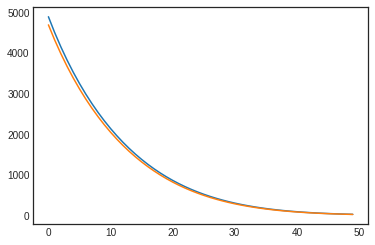

In [189]:
plt.plot(plot_iter, plot_loss_train, plot_loss_test)
display.clear_output(wait=True)
plt.show()

In [200]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_review(t):
    
    categories = {0: "Positive",1:"Negative", 2:"Neutral", 3:"Very Positive", 4:"Very Negative"}
    
  
    tokenized = [tok.text for tok in nlp.tokenizer(t)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)
    #print(prediction)
    #print(prediction.max())
    #print(categories)
    _, pred = torch.max(prediction, 1) 
    #print(pred.item()) 
    return categories[pred.item()]

In [201]:
classify_review("never buy this product.")

'Very Positive'

In [193]:
from google.colab import files

In [194]:
uploaded=files.upload()

Saving test_sent.pkl to test_sent.pkl


In [195]:
f1=open('test_sent.pkl','rb')
tst=pickle.load(f1)
f1.close()

In [197]:
import random
import numpy as np
np.random.seed(43)

In [202]:
for i in range(10):
  r_n=random.choice(tst)
  p=classify_review(r_n)
  print(f'{r_n} | sentiment : {p}')

For a shoot - 'em - up , Ballistic is oddly lifeless . | sentiment : Positive
( Howard ) so good as Leon Barlow ... that he hardly seems to be acting . | sentiment : Negative
It has the courage to wonder about big questions with sincerity and devotion . | sentiment : Negative
The stupidest , most insulting movie of 2002 's first quarter . | sentiment : Positive
Marvelous , merry and , yes , melancholy film . | sentiment : Neutral
However , it lacks grandeur and that epic quality often associated with Stevenson 's tale as well as with earlier Disney efforts . | sentiment : Positive
Its save-the-planet message clashes with its crass marketing . | sentiment : Positive
Run , do n't walk , to see this barbed and bracing comedy on the big screen . | sentiment : Neutral
This is one of Polanski 's best films . | sentiment : Neutral
Must-see viewing for anyone involved in the high-tech industry . | sentiment : Neutral
